In [29]:
!rsync -r mats@35.226.175.240:/home/mats/collected-metrics/ ./collected-metrics

In [30]:
!ls collected-metrics

2021-02-23__21-26-28__event-times.csv 2021-02-24__09-26-03__event-times.csv
2021-02-23__21-26-28__metrics.csv     2021-02-24__09-26-03__metrics.csv
2021-02-23__22-00-17__event-times.csv 2021-02-24__09-37-14__event-times.csv
2021-02-23__22-00-17__metrics.csv     2021-02-24__09-37-14__metrics.csv
2021-02-23__22-27-42__event-times.csv 2021-02-24__09-44-39__event-times.csv
2021-02-23__22-27-42__metrics.csv     2021-02-24__09-44-39__metrics.csv


In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
benchmark_id = '2021-02-24__09-44-39'

In [33]:
metrics_df = pd.read_csv(f'collected-metrics/{benchmark_id}__metrics.csv')
event_times_df = pd.read_csv(f'collected-metrics/{benchmark_id}__event-times.csv')

print(f'Received {len(event_times_df)} tuples in {len(metrics_df)} segments')

Received 1000000 tuples in 100 segments


In [34]:
event_times_df['timeSinceStartS'] = (event_times_df['eventTime'] - min(event_times_df['eventTime'])) / 1000
event_times_df['transferDurationMs'] = event_times_df['flinkSinkTime'] - event_times_df['eventTime']
event_times_df.head()

,eventTime,flinkSinkTime,timeSinceStartS,transferDurationMs
0,1614159928006,1614159928006,65.656,0
1,1614159928006,1614159928007,65.656,1
2,1614159928006,1614159928007,65.656,1
3,1614159928006,1614159928007,65.656,1
4,1614159928006,1614159928007,65.656,1


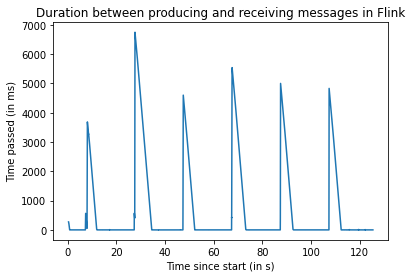

In [49]:
ax = sns.lineplot(data=event_times_df.sample(2000), x='timeSinceStartS', y='transferDurationMs')
ax.set_title('Duration between producing and receiving messages in Flink')
ax.set_xlabel('Time since start (in s)')
ax.set_ylabel('Time passed (in ms)')
plt.show()

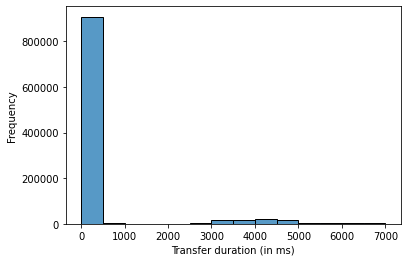

In [61]:
ax = sns.histplot(event_times_df['transferDurationMs'], binwidth=500)
ax.set_xlabel('Transfer duration (in ms)')
ax.set_ylabel('Frequency')
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


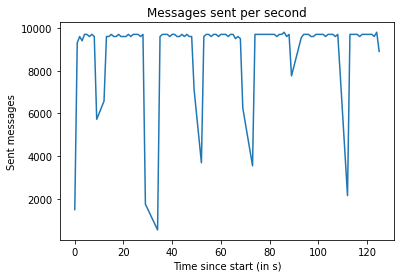

In [35]:
data = event_times_df['timeSinceStartS'].apply(lambda x: round(x)).value_counts()

ax = sns.lineplot(data.index, data)
ax.set_title('Messages sent per second')
ax.set_xlabel('Time since start (in s)')
ax.set_ylabel('Sent messages')
plt.show()

In [37]:
for index, row in metrics_df.iterrows():
    segment_start_time = row['segmentStartTime']
    segment_end_time = row['segmentEndTime']
    segment_push_time = row['segmentPushTime']
    
    cond = (event_times_df['eventTime'] >= segment_start_time) & (event_times_df['eventTime'] <= segment_end_time)
    event_times_df.loc[cond, 'segmentPushTime'] = segment_push_time

In [8]:
def assign_segment_push_time(event_time: int):
    series = metrics_df.loc[(metrics_df['segmentStartTime'] <= event_time) & (event_time <= metrics_df['segmentEndTime'])]['segmentPushTime']
    return max(series.to_numpy())

event_times_df['segmentPushTime'] = event_times_df['eventTime'].apply(assign_segment_push_time)

In [38]:
event_times_df['event_time_latency_in_s'] = (event_times_df['segmentPushTime'] - event_times_df['eventTime']) / 1000

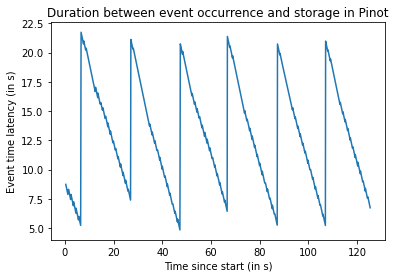

In [47]:
ax = sns.lineplot(data=event_times_df.sample(2000), x='timeSinceStartS', y='event_time_latency_in_s')
ax.set_title('Duration between event occurrence and storage in Pinot')
ax.set_xlabel('Time since start (in s)')
ax.set_ylabel('Event time latency (in s)')
plt.show()